In [64]:
from google.colab import files
uploaded = files.upload()

Saving historical_data.csv to historical_data (1).csv
Saving fear_greed_index.csv to fear_greed_index (1).csv


In [79]:
import pandas as pd, numpy as np, os
trades = pd.read_csv('historical_data.csv')
fg = pd.read_csv('fear_greed_index.csv')

In [69]:
trades.columns = [c.strip().lower().replace(' ', '_') for c in trades.columns]
fg.columns     = [c.strip().lower().replace(' ', '_') for c in fg.columns]

In [70]:
if 'timestamp_ist' in trades.columns:
    trades['timestamp'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
else:
    # fallback: try numeric unix timestamp conversion (auto-detect scale)
    def _auto_ts(x):
        try:
            x = int(float(x))
        except:
            return pd.NaT
        if x > 1e15:
            return pd.to_datetime(x, unit='us')
        if x > 1e12:
            return pd.to_datetime(x, unit='ms')
        if x > 1e9:
            return pd.to_datetime(x, unit='s')
        return pd.NaT
    trades['timestamp'] = trades['timestamp'].apply(_auto_ts) if 'timestamp' in trades.columns else pd.NaT

In [71]:
if 'date' in trades.columns:
    trades = trades.drop(columns=['date'])
trades['date'] = trades['timestamp'].dt.date

In [72]:
trades = trades.drop_duplicates()
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'start_position', 'fee']
for col in numeric_cols:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

In [73]:
if 'size_tokens' in trades.columns:
    trades = trades[trades['size_tokens'].notna()]

In [74]:
daily = trades.groupby('date').agg(
    total_trades = ('account', 'count'),
    total_volume_tokens = ('size_tokens', 'sum'),
    total_volume_usd = ('size_usd', 'sum'),
    net_pnl = ('closed_pnl', 'sum'),
    avg_pnl = ('closed_pnl', 'mean'),
    pct_profitable = ('closed_pnl', lambda x: (x > 0).mean()),
    buy_count = ('side', lambda s: (s.str.lower() == 'buy').sum() if s.dtype == 'O' else 0),
    sell_count = ('side', lambda s: (s.str.lower() == 'sell').sum() if s.dtype == 'O' else 0)
).reset_index()
daily['buy_sell_ratio'] = daily['buy_count'] / (daily['sell_count'] + 1e-9)

In [75]:
if 'date' in fg.columns:
    fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
elif 'timestamp' in fg.columns:
    # if fg has unix timestamp numeric column called timestamp
    fg['timestamp'] = pd.to_numeric(fg['timestamp'], errors='coerce')
    fg['date'] = pd.to_datetime(fg['timestamp'], unit='ms', errors='coerce').dt.date


In [76]:
merged = daily.merge(fg[['date','classification','value']].drop_duplicates('date'), on='date', how='left')

In [77]:
print("trades:", trades.shape, "daily:", daily.shape, "merged:", merged.shape)
display(merged.head())

trades: (211224, 17) daily: (480, 10) merged: (480, 12)


,date,total_trades,total_volume_tokens,total_volume_usd,net_pnl,avg_pnl,pct_profitable,buy_count,sell_count,buy_sell_ratio,classification,value
0,2023-05-01,3,0.25130,477.00,0.000000,0.000000,0.000000,3,0,3.000000e+09,Greed,63.0
1,2023-12-05,9,11.80901,50005.83,0.000000,0.000000,0.000000,7,2,3.500000e+00,Extreme Greed,75.0
2,2023-12-14,11,4092.28901,113203.35,-205.434737,-18.675885,0.363636,5,6,8.333333e-01,Greed,72.0
3,2023-12-15,2,3558.00000,10609.95,-24.632034,-12.316017,0.000000,2,0,2.000000e+09,Greed,70.0
4,2023-12-16,3,39897.00000,15348.77,0.000000,0.000000,0.000000,3,0,3.000000e+09,Greed,67.0


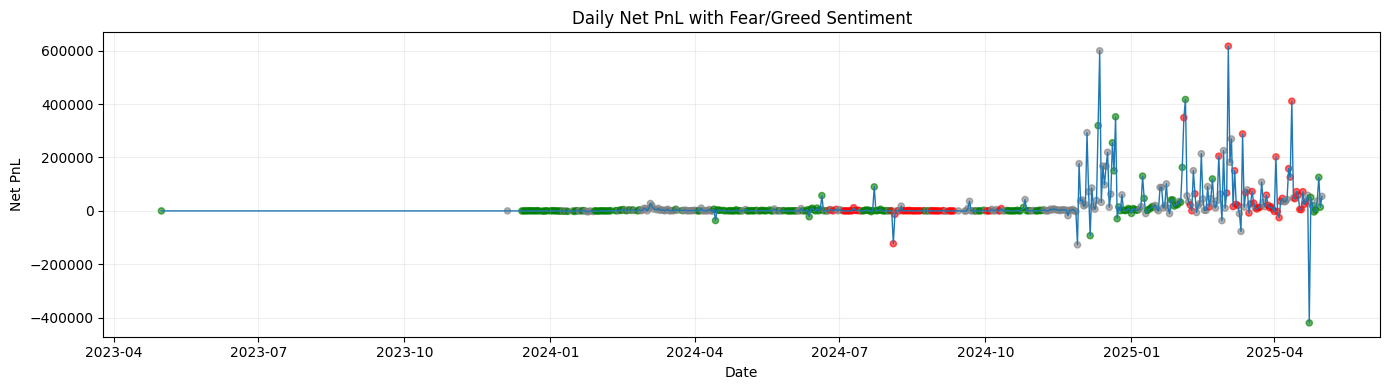

In [82]:
import matplotlib.pyplot as plt
os.makedirs('outputs', exist_ok=True)
colors = merged['classification'].map({'Fear': 'red', 'Greed': 'green'})  # map known values
colors = colors.fillna('gray')  # neutral color for missing sentiment

plt.figure(figsize=(14,4))
plt.plot(merged['date'], merged['net_pnl'], label='Net PnL', linewidth=1)
plt.scatter(merged['date'], merged['net_pnl'], c=colors, alpha=0.6, s=20)
plt.title("Daily Net PnL with Fear/Greed Sentiment")
plt.xlabel("Date")
plt.ylabel("Net PnL")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('outputs/netpnl_with_sentiment.png', dpi=150)
plt.show()

In [83]:
from scipy.stats import ttest_ind, mannwhitneyu
fear = merged[merged['classification'] == 'Fear']['net_pnl'].dropna()
greed = merged[merged['classification'] == 'Greed']['net_pnl'].dropna()

if len(fear) > 1 and len(greed) > 1:
    t_stat, p_val = ttest_ind(fear, greed, equal_var=False)
    mw_stat, mw_p = mannwhitneyu(fear, greed, alternative='two-sided')
    print("T-test p-value:", p_val)
    print("Mann-Whitney p-value:", mw_p)
else:
    print("Not enough data in Fear or Greed groups to run statistical tests.")

T-test p-value: 0.021709969966269897
Mann-Whitney p-value: 0.009470524637068167


In [84]:
os.makedirs('csv_files', exist_ok=True)
daily.to_csv('csv_files/daily_aggregates.csv', index=False)
merged.to_csv('csv_files/merged_daily_sentiment.csv', index=False)
print("Saved: csv_files/daily_aggregates.csv and csv_files/merged_daily_sentiment.csv")

Saved: csv_files/daily_aggregates.csv and csv_files/merged_daily_sentiment.csv
